In [1]:
from __future__ import division, print_function
import os
import sys
import cPickle as pickle
path = "/Users/adrian/projects/ophiuchus/build/lib.macosx-10.5-x86_64-2.7/"
if path not in sys.path:
    sys.path.append(path)

# Third-party
import astropy.coordinates as coord
import astropy.units as u
uno = u.dimensionless_unscaled
import matplotlib as mpl
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np

# Custom
import gary.coordinates as gc
import gary.dynamics as gd
import gary.integrate as gi
import gary.potential as gp
from gary.units import galactic
from scipy.signal import argrelmin

from streammorphology.ensemble import align_ensemble
import ophiuchus.potential as op
from ophiuchus.data import OphiuchusData
from ophiuchus.util import integrate_forward_backward
from ophiuchus.coordinates import Ophiuchus
from ophiuchus import galactocentric_frame, vcirc, vlsr

plotpath = "/Users/adrian/projects/ophiuchus-paper/figures/"
if not os.path.exists(plotpath):
    os.mkdir(plotpath)

In [2]:
top_path = "/Users/adrian/projects/ophiuchus/output/orbitfit/"
ophdata = OphiuchusData()
all_names = ["static_mw"] + ["barred_mw_{}".format(i) for i in range(1,10)]
short_names = ["static"] + ["bar{}".format(i) for i in range(1,10)]
name_map = dict(zip(all_names, short_names))

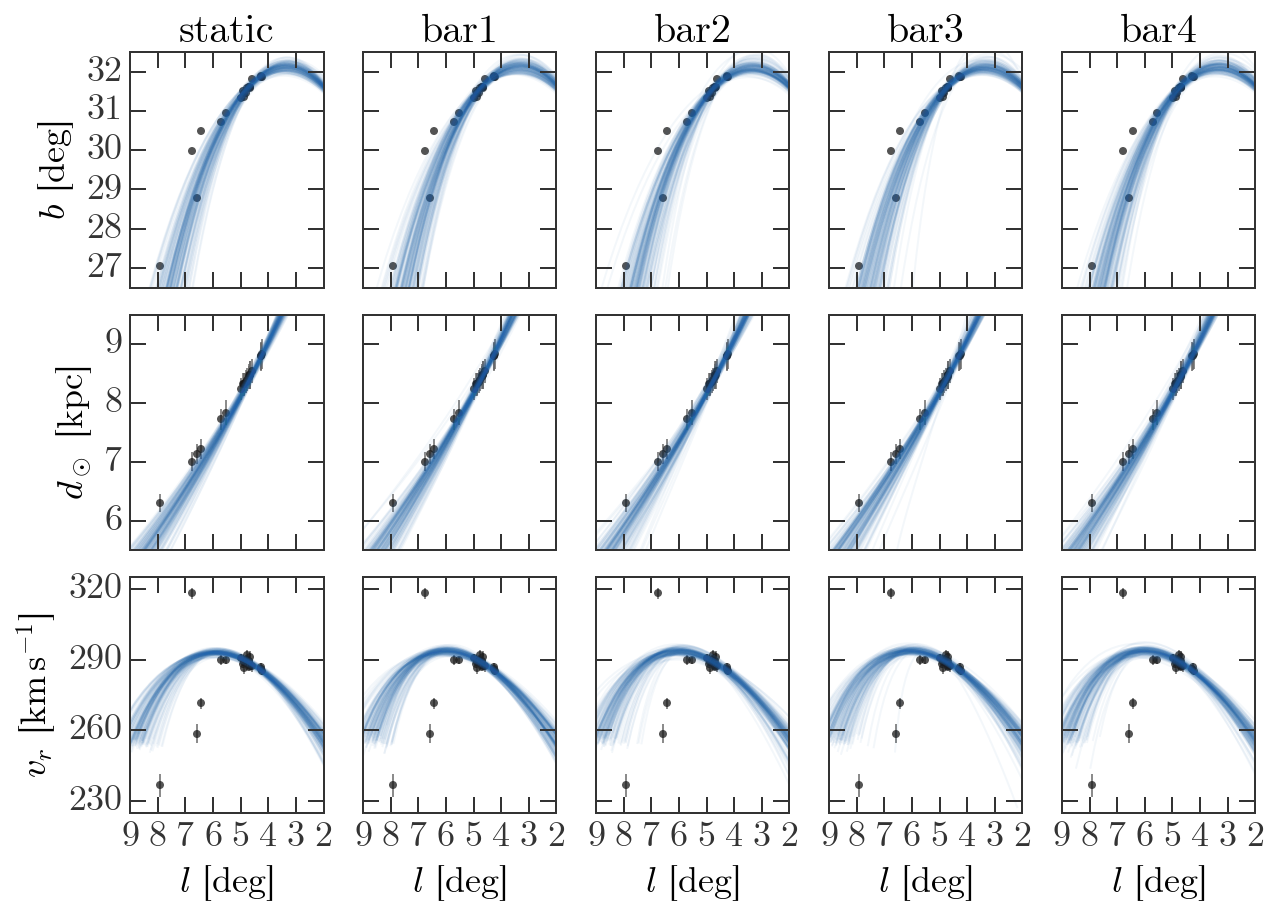

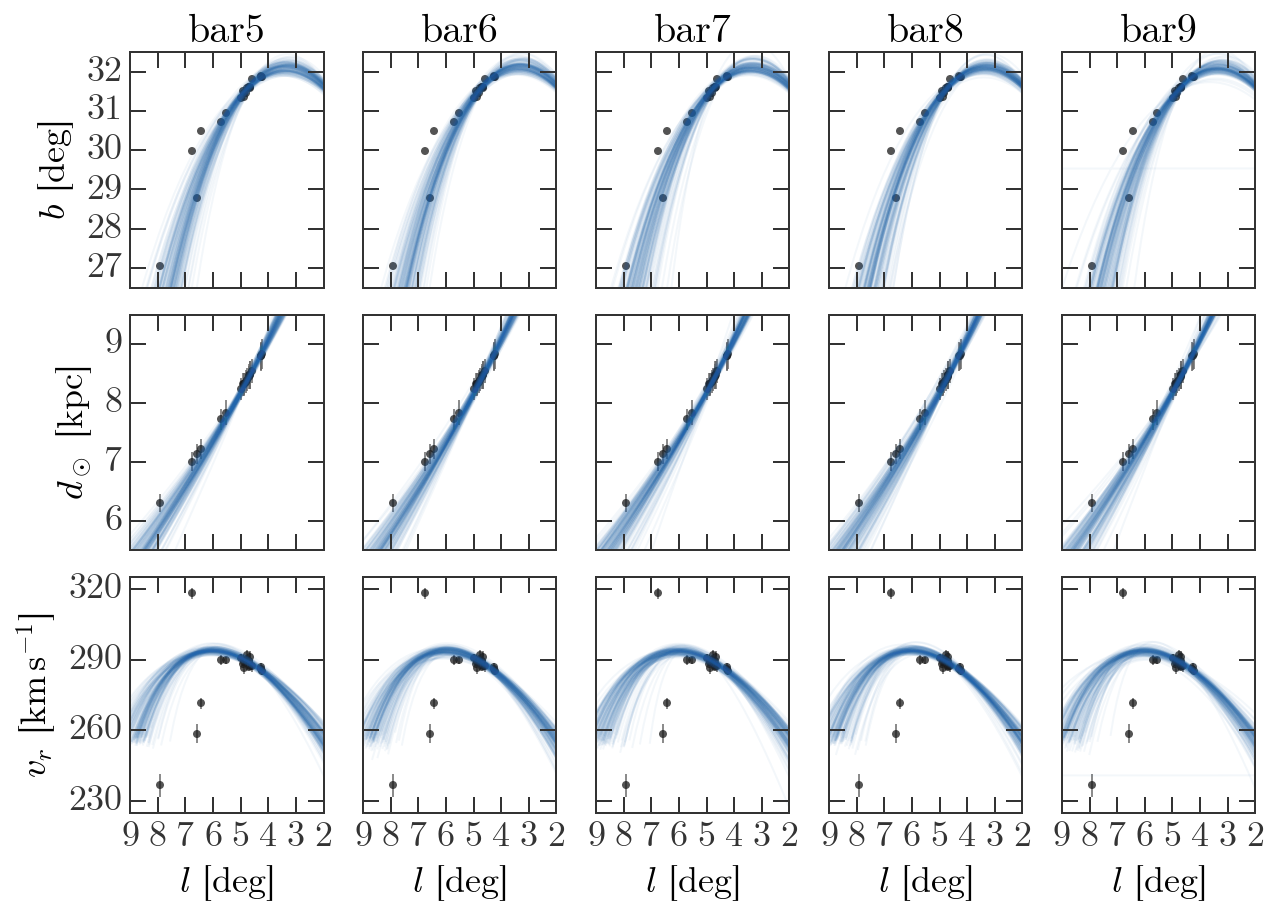

In [74]:
for n,name_subset in enumerate([all_names[:5], all_names[5:]]):
    fig,axes = pl.subplots(3,5,figsize=(9,6.5),sharex=True,sharey='row')

    for i,name in enumerate(name_subset):
        axes[0,i].set_title(name_map[name], fontsize=20)
        axes[2,i].set_xlabel("$l$ [deg]", fontsize=18)

        path = os.path.join(top_path, name)
        w0 = np.load(os.path.join(path, 'w0.npy'))[:128]
        pot = op.load_potential(name)

        orbit_w = integrate_forward_backward(pot, w0, t_forw=16., t_back=-10)
        w_coord = galactocentric_frame.realize_frame(coord.CartesianRepresentation(orbit_w.T[:3]*u.kpc))\
                                      .transform_to(coord.Galactic)
        w_oph = w_coord.transform_to(Ophiuchus)
    #     w_vel = gc.vgal_to_hel(w_coord, orbit_w.T[3:]*u.kpc/u.Myr,
    #                            galactocentric_frame=galactocentric_frame,
    #                            vcirc=vcirc, vlsr=vlsr)
        vr = [gc.vgal_to_hel(w_coord[j], orbit_w[:,j].T[3:]*u.kpc/u.Myr, galactocentric_frame=galactocentric_frame, vcirc=vcirc, vlsr=vlsr)[2].to(u.km/u.s).value for j in range(len(w0))]

        # global style stuff
        orbit_style = dict(marker=None, color='#2166AC', alpha=0.05)
        data_style = dict(marker='o', ms=4, ls='none', ecolor='#666666', alpha=0.75)

        # sky
        _tmp = data_style.copy()
        _tmp.pop('ecolor')
        axes[0,i].plot(ophdata.coord.l.degree, ophdata.coord.b.degree, **_tmp)
        axes[0,i].plot(w_coord.l.degree.T, w_coord.b.degree.T, **orbit_style)
        axes[0,i].yaxis.set_ticks(np.arange(27,32+1))

        # distance
        axes[1,i].errorbar(ophdata.coord.l.degree, ophdata.coord.distance.to(u.kpc).value, 
                           ophdata.coord_err['distance'].to(u.kpc).value, **data_style)
        axes[1,i].plot(w_coord.l.degree.T, w_coord.distance.to(u.kpc).value.T, **orbit_style)
        axes[1,i].yaxis.set_ticks(np.arange(6,9+1))

        # radial velocity
        axes[2,i].errorbar(ophdata.coord.l.degree, ophdata.veloc['vr'].to(u.km/u.s).value, 
                           ophdata.veloc_err['vr'].to(u.km/u.s).value, **data_style)
        axes[2,i].plot(w_coord.l.degree.T, np.vstack(vr).T, **orbit_style)
        axes[2,i].yaxis.set_ticks(np.arange(230,320+1,30))

    axes[0,0].set_xlim(9,2)

    axes[0,0].set_ylabel("$b$ [deg]", fontsize=18)
    axes[0,0].set_ylim(26.5, 32.5)

    axes[1,0].set_ylabel(r"$d_\odot$ [kpc]", fontsize=18)
    axes[1,0].set_ylim(5.5, 9.5)

    axes[2,0].set_ylabel(r"$v_r$ [${\rm km}\,{\rm s}^{-1}$]", fontsize=18)
    axes[2,0].set_ylim(225, 325)

    fig.tight_layout()
    
    fig.savefig(os.path.join(plotpath, "orbitfits-{}.pdf".format(n)))
    fig.savefig(os.path.join(plotpath, "orbitfits-{}.png".format(n)))

---

### Plot mean orbits in XYZ

In [9]:
split_ix = 300
every = 30

mean_w0s = np.zeros((len(all_names), 6))
for i,name in enumerate(all_names):
    with open(os.path.join(top_path, name, 'sampler.pickle'), 'rb') as f:
        sampler = pickle.load(f)
    _x0 = np.vstack(sampler.chain[:,split_ix::every,:5])
    mean_x0 = np.mean(_x0, axis=0)
    std_x0 = np.std(_x0, axis=0)
    
    transforms = [
        lambda x: np.degrees(x),
        lambda x: x,
        lambda x: (x*u.radian/u.Myr).to(u.mas/u.yr).value,
        lambda x: (x*u.radian/u.Myr).to(u.mas/u.yr).value,
        lambda x: (x*u.kpc/u.Myr).to(u.km/u.s).value
    ]
    cols = []
    for j,_mean,_std in zip(range(len(mean_x0)), mean_x0, std_x0):
        cols.append("{:.3f} {:.3f}".format(transforms[j](_mean), transforms[j](_std)))
    print(" & ".join(cols))
    
    mul = (mean_x0[2]*u.radian/u.Myr).to(u.mas/u.yr).value
    
    
    mean_w0s[i] = ophdata._mcmc_sample_to_w0(mean_x0)[:,0]

-0.032 0.051 & 8.353 0.055 & -7.217 0.095 & 0.935 0.100 & 289.080 0.866
-0.035 0.054 & 8.402 0.054 & -7.178 0.097 & 0.942 0.105 & 289.015 0.913
-0.029 0.053 & 8.402 0.053 & -7.196 0.095 & 0.925 0.106 & 288.896 1.053
-0.040 0.056 & 8.402 0.056 & -7.190 0.101 & 0.930 0.106 & 289.020 0.987
-0.030 0.057 & 8.411 0.057 & -7.173 0.098 & 0.947 0.102 & 289.090 1.004
-0.031 0.052 & 8.410 0.052 & -7.192 0.098 & 0.926 0.102 & 289.118 0.933
-0.032 0.052 & 8.402 0.053 & -7.182 0.102 & 0.946 0.111 & 289.028 0.973
-0.036 0.054 & 8.410 0.047 & -7.180 0.099 & 0.939 0.108 & 288.971 0.980
-0.028 0.052 & 8.416 0.054 & -7.176 0.095 & 0.936 0.105 & 289.146 1.034
-0.025 0.053 & 8.414 0.052 & -7.179 0.096 & 0.936 0.105 & 288.924 0.977


In [4]:
_tmp_cache = dict()

integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating


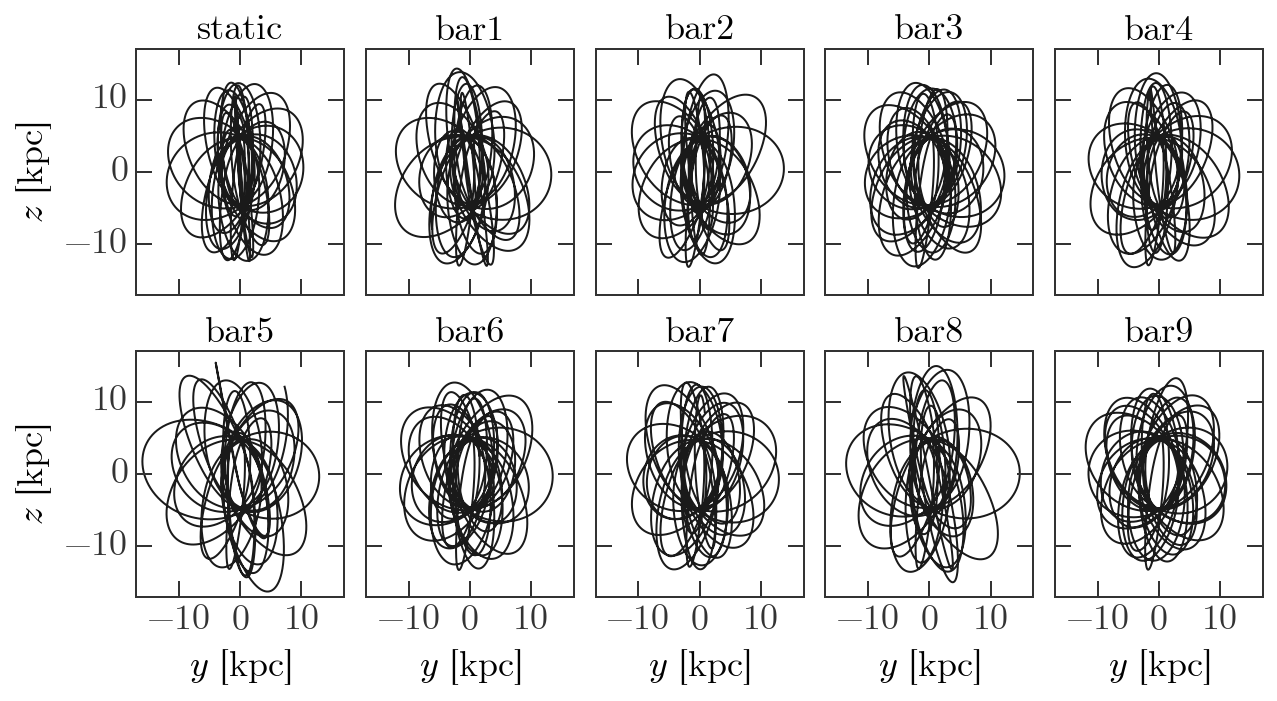

In [5]:
fig,axes = pl.subplots(2,5,figsize=(9,5),sharex=True,sharey=True)
for i,name in enumerate(all_names):
    path = os.path.join(top_path, name)
    this_w0 = mean_w0s[i]
    pot = op.load_potential(name)
    
    if name not in _tmp_cache:
        print("integrating")
        t,w = pot.integrate_orbit(this_w0, dt=-1., nsteps=6000., Integrator=gi.DOPRI853Integrator)
        _tmp_cache[name] = w
    else:
        w = _tmp_cache[name]
    
    axes.flat[i].plot(w[:,0,1], w[:,0,2], marker=None)
    axes.flat[i].set_title(name_map[name], fontsize=18)

    if i > 4:
        axes.flat[i].set_xlabel("$y$ [kpc]", fontsize=18)

axes[0,0].set_ylabel("$z$ [kpc]", fontsize=18)
axes[1,0].set_ylabel("$z$ [kpc]", fontsize=18)

_s = 17
axes[0,0].set_xlim(-_s,_s)
axes[0,0].set_ylim(-_s,_s)

axes[0,0].xaxis.set_ticks([-10,0,10])
axes[0,0].yaxis.set_ticks([-10,0,10])

fig.tight_layout()

fig.savefig(os.path.join(plotpath, "orbit-yz.png"), dpi=300)
fig.savefig(os.path.join(plotpath, "orbit-yz.pdf"))